In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [9]:
def get_anomalies(test, labels):
    scaled_anomalies = 0
    contextual_anomalies = 0
    total_anomalies = 0
    dims_without_anomaly = set()
    for i in range(test.shape[1]):
        l = labels[:, i]
        y = test[:, i]

        sm = 0
        anomalies = []
        for j in range(len(l)):
            x = l[j]
            if x == 1:
                sm += 1
            else:
                if sm > 0:
                    anomalies.append((j, sm))
                    sm = 0
        for j, sm in anomalies:
            total_anomalies += sm
            l1 = max(j-sm, 0)
            l2 = max(j-2*sm, 0)
            a, b, c = y[l1:l1+sm].mean() / y[l2:l2+sm].mean(), y[l1:l1+sm].mean() / y[j:j+sm].mean(), y[l1:l1+sm].mean() / y.mean()
            ter = 1.2
            ter4 = 2
            ter2 = 0.83
            ter3 = 0.5

            if a > ter and b > ter and c > ter:
                scaled_anomalies += sm
            elif y[l1:l1+sm].max()/y[l2:l2+sm].max() > ter4 and  y[l1:l1+sm].max()/y[j:j+sm].max() > ter4:
                scaled_anomalies += sm

            if a < ter2 and b < ter2 and c < ter2:
                contextual_anomalies += sm
            elif y[l1:l1+sm].min()/y[l2:l2+sm].min() < ter3 and  y[l1:l1+sm].min()/y[j:j+sm].min() < ter3:
                contextual_anomalies += sm
        
            if (np.all(y[l1:l1+sm] == y[l2:l2+sm]) or np.all(y[l1:l1+sm] == y[j:j+sm])):
                dims_without_anomaly.add(i)
    return scaled_anomalies, contextual_anomalies, len(dims_without_anomaly), total_anomalies

In [10]:
datasets = ["SMD", "SMAP", "MSL", "UCR", "SWaT", "WADI"]
root = 'processed/'
import numpy as np
res = {}
for dataset in datasets:
    all_files = os.listdir(root + dataset)
    entities = []
    for file in all_files:
        if file[-9:] == 'train.npy':
            entities.append(file[:-10])
    for entity in entities:
        res[(dataset,entity)] = {}
        entityf = entity
        if entity:
            entityf +='_'
        labels = np.load(f"./processed/{dataset}/{entityf}labels.npy")
        train = np.load(f"./processed/{dataset}/{entityf}train.npy")
        test = np.load(f"./processed/{dataset}/{entityf}test.npy")
        scaled_anomalies, contextual_anomalies, dims_without_anomaly, total_anomalies = get_anomalies(test, labels)
        res[(dataset,entity)]['scaled_anomalies'] = round(scaled_anomalies *100 / (test.shape[0] * test.shape[1]), 3)
        res[(dataset,entity)]['contextual_anomalies'] = round(contextual_anomalies*100 / (test.shape[0] * test.shape[1]), 3)
        res[(dataset,entity)]['total_anomalies'] = round(total_anomalies*100 / (test.shape[0] * test.shape[1]), 3)
        res[(dataset,entity)]['total_dims'] = test.shape[1]
        res[(dataset,entity)]['dims_without_anomaly'] = dims_without_anomaly

df = pd.DataFrame(res).T
df.index.name = 'dataset'
df.sort_index().to_excel("other_results/anomaly_types.xlsx")

<ipython-input-9-03b5691e47f5>:24: RuntimeWarning: divide by zero encountered in double_scalars
  a, b, c = y[l1:l1+sm].mean() / y[l2:l2+sm].mean(), y[l1:l1+sm].mean() / y[j:j+sm].mean(), y[l1:l1+sm].mean() / y.mean()
<ipython-input-9-03b5691e47f5>:37: RuntimeWarning: invalid value encountered in double_scalars
  elif y[l1:l1+sm].min()/y[l2:l2+sm].min() < ter3 and  y[l1:l1+sm].min()/y[j:j+sm].min() < ter3:
<ipython-input-9-03b5691e47f5>:32: RuntimeWarning: divide by zero encountered in double_scalars
  elif y[l1:l1+sm].max()/y[l2:l2+sm].max() > ter4 and  y[l1:l1+sm].max()/y[j:j+sm].max() > ter4:
<ipython-input-9-03b5691e47f5>:37: RuntimeWarning: divide by zero encountered in double_scalars
  elif y[l1:l1+sm].min()/y[l2:l2+sm].min() < ter3 and  y[l1:l1+sm].min()/y[j:j+sm].min() < ter3:
<ipython-input-9-03b5691e47f5>:24: RuntimeWarning: invalid value encountered in double_scalars
  a, b, c = y[l1:l1+sm].mean() / y[l2:l2+sm].mean(), y[l1:l1+sm].mean() / y[j:j+sm].mean(), y[l1:l1+sm].mean(

In [11]:
datasets = ["SMD", "SMAP", "MSL", "UCR", "SWaT", "WADI"]
root = 'processed/'
res = {}
for dataset in datasets:
    res[dataset] = {}
    res[dataset]['scaled_anomalies'] = 0
    res[dataset]['contextual_anomalies'] = 0
    res[dataset]['total_test_size'] = 0
    all_files = os.listdir(root + dataset)
    entities = []
    for file in all_files:
        if file[-9:] == 'train.npy':
            entities.append(file[:-10])
    for entity in entities:
        entityf = entity
        if entity:
            entityf +='_'
        labels = np.load(f"./processed/{dataset}/{entityf}labels.npy")
        train = np.load(f"./processed/{dataset}/{entityf}train.npy")
        test = np.load(f"./processed/{dataset}/{entityf}test.npy")
        scaled_anomalies, contextual_anomalies, _, _ = get_anomalies(test, labels)
        res[dataset]['scaled_anomalies'] += scaled_anomalies
        res[dataset]['contextual_anomalies'] += contextual_anomalies
        res[dataset]['total_test_size'] += (test.shape[0] * test.shape[1])

df = pd.DataFrame(res)
np.round((df / df.loc['total_test_size']) * 100, 2).T.sort_index()[['scaled_anomalies', 'contextual_anomalies']].sort_index().to_excel("other_results/anomaly_types_total.xlsx")

<ipython-input-9-03b5691e47f5>:24: RuntimeWarning: divide by zero encountered in double_scalars
  a, b, c = y[l1:l1+sm].mean() / y[l2:l2+sm].mean(), y[l1:l1+sm].mean() / y[j:j+sm].mean(), y[l1:l1+sm].mean() / y.mean()
<ipython-input-9-03b5691e47f5>:37: RuntimeWarning: invalid value encountered in double_scalars
  elif y[l1:l1+sm].min()/y[l2:l2+sm].min() < ter3 and  y[l1:l1+sm].min()/y[j:j+sm].min() < ter3:
<ipython-input-9-03b5691e47f5>:32: RuntimeWarning: divide by zero encountered in double_scalars
  elif y[l1:l1+sm].max()/y[l2:l2+sm].max() > ter4 and  y[l1:l1+sm].max()/y[j:j+sm].max() > ter4:
<ipython-input-9-03b5691e47f5>:37: RuntimeWarning: divide by zero encountered in double_scalars
  elif y[l1:l1+sm].min()/y[l2:l2+sm].min() < ter3 and  y[l1:l1+sm].min()/y[j:j+sm].min() < ter3:
<ipython-input-9-03b5691e47f5>:24: RuntimeWarning: invalid value encountered in double_scalars
  a, b, c = y[l1:l1+sm].mean() / y[l2:l2+sm].mean(), y[l1:l1+sm].mean() / y[j:j+sm].mean(), y[l1:l1+sm].mean(

In [12]:
dataset = 'SMD'
entity = 'machine-1-1'
entityf = entity
if entity:
    entityf +='_'
labels = np.load(f"./processed/{dataset}/{entityf}labels.npy")
train = np.load(f"./processed/{dataset}/{entityf}train.npy")
test = np.load(f"./processed/{dataset}/{entityf}test.npy")

In [13]:
scaled_anomalies = []
contextual_anomalies = []
no_anomalies = []
for i in range(test.shape[1]):
    l = labels[:, i]
    y = test[:, i]

    sm = 0
    anomalies = []
    for j in range(len(l)):
        x = l[j]
        if x == 1:
            sm += 1
        else:
            if sm > 0:
                anomalies.append((j, sm))
                sm = 0
    for j, sm in anomalies:
        l1 = max(j-sm, 0)
        l2 = max(j-2*sm, 0)
        a, b, c = y[l1:l1+sm].mean() / y[l2:l2+sm].mean(), y[l1:l1+sm].mean() / y[j:j+sm].mean(), y[l1:l1+sm].mean() / y.mean()
        ter = 1.2
        if a > ter and b > ter and c > ter:
            scaled_anomalies.append((i, j-sm))

        ter4 = 2
        if y[l1:l1+sm].max()/y[l2:l2+sm].max() > ter4 and  y[l1:l1+sm].max()/y[j:j+sm].max() > ter4:
            scaled_anomalies.append((i, j-sm))

        ter2 = 0.83
        if a < ter2 and b < ter2 and c < ter2:
            contextual_anomalies.append((i, j-sm))
        
        ter3 = 0.5
        if y[l1:l1+sm].min()/y[l2:l2+sm].min() < ter3 and  y[l1:l1+sm].min()/y[j:j+sm].min() < ter3:
            contextual_anomalies.append((i, j-sm))
    
        if np.all(y[l1:l1+sm] == y[l2:l2+sm]) or np.all(y[l1:l1+sm] == y[j:j+sm]):
            no_anomalies.append((i, j-sm))

<ipython-input-13-dee8f7836401>:35: RuntimeWarning: invalid value encountered in double_scalars
  if y[l1:l1+sm].min()/y[l2:l2+sm].min() < ter3 and  y[l1:l1+sm].min()/y[j:j+sm].min() < ter3:
<ipython-input-13-dee8f7836401>:35: RuntimeWarning: divide by zero encountered in double_scalars
  if y[l1:l1+sm].min()/y[l2:l2+sm].min() < ter3 and  y[l1:l1+sm].min()/y[j:j+sm].min() < ter3:
<ipython-input-13-dee8f7836401>:21: RuntimeWarning: divide by zero encountered in double_scalars
  a, b, c = y[l1:l1+sm].mean() / y[l2:l2+sm].mean(), y[l1:l1+sm].mean() / y[j:j+sm].mean(), y[l1:l1+sm].mean() / y.mean()
<ipython-input-13-dee8f7836401>:27: RuntimeWarning: divide by zero encountered in double_scalars
  if y[l1:l1+sm].max()/y[l2:l2+sm].max() > ter4 and  y[l1:l1+sm].max()/y[j:j+sm].max() > ter4:


<ipython-input-14-953eb69f3824>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20, 5))


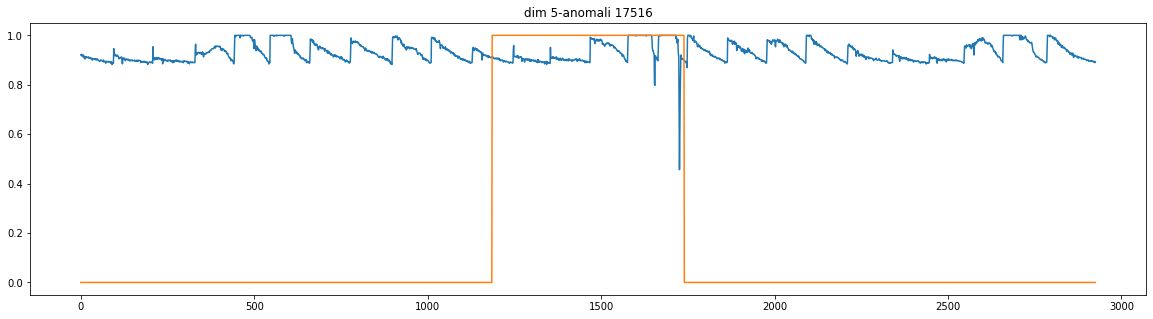

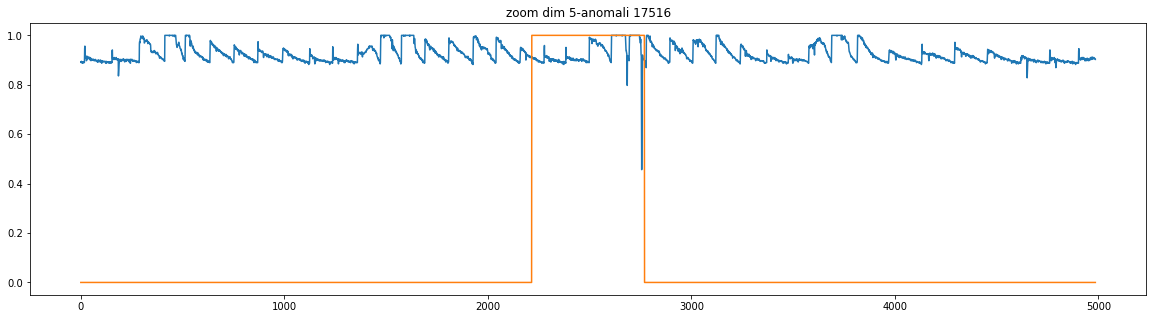

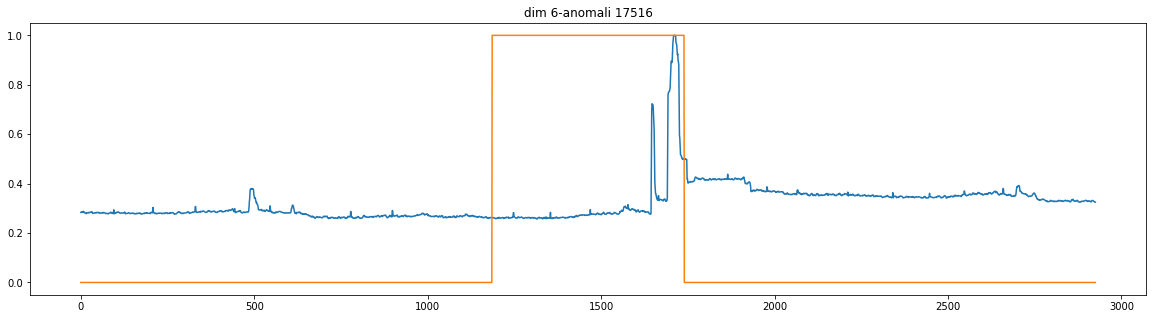

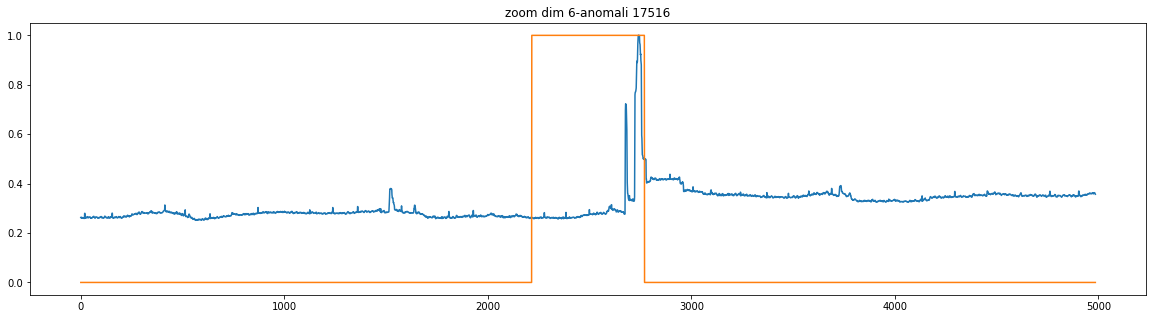

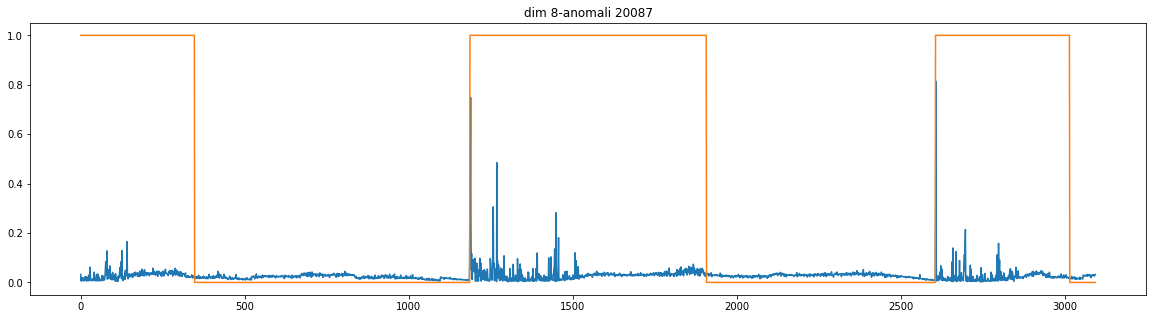

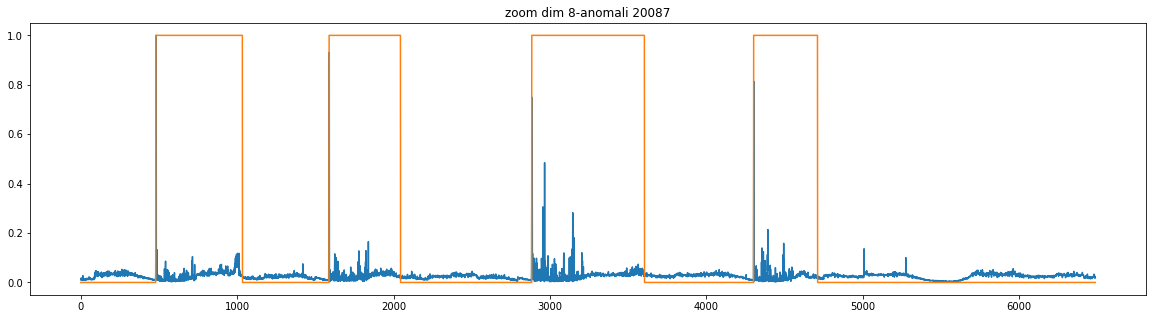

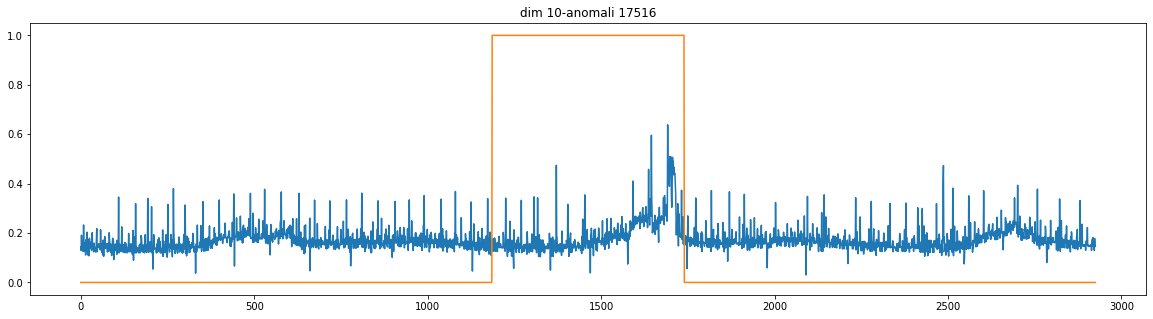

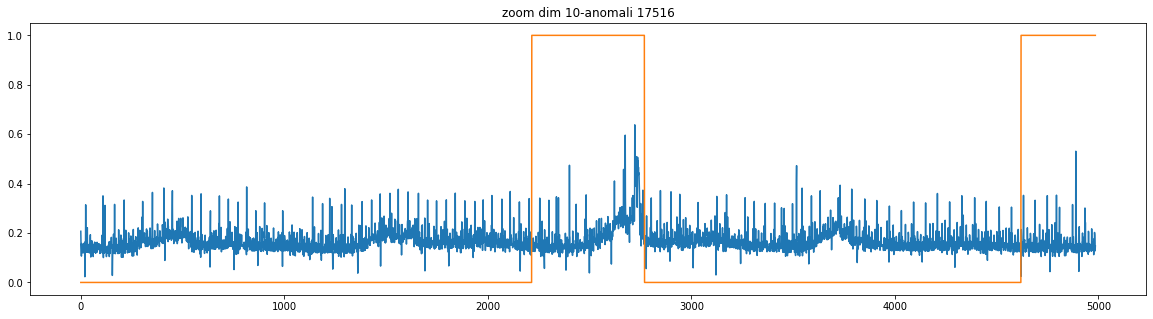

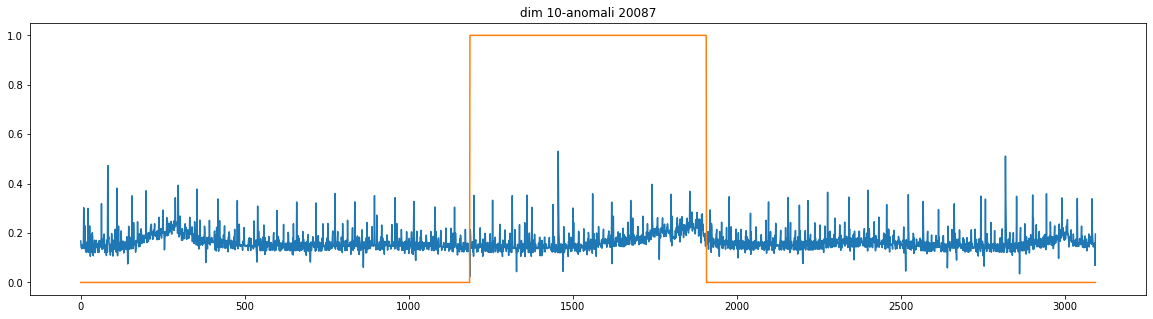

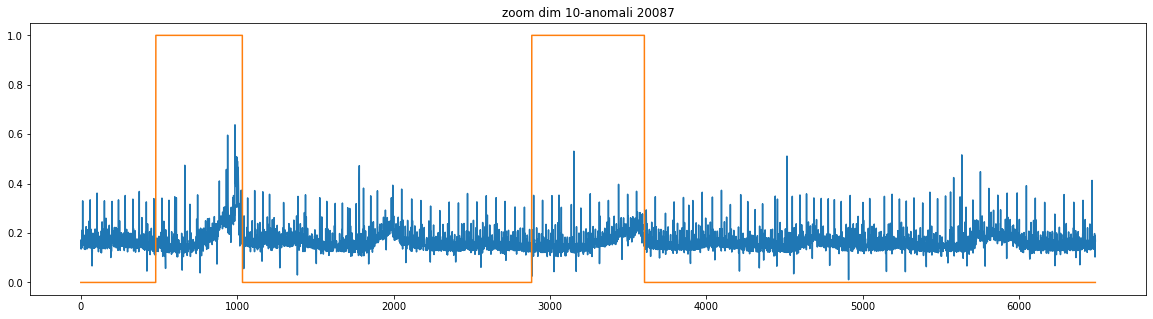

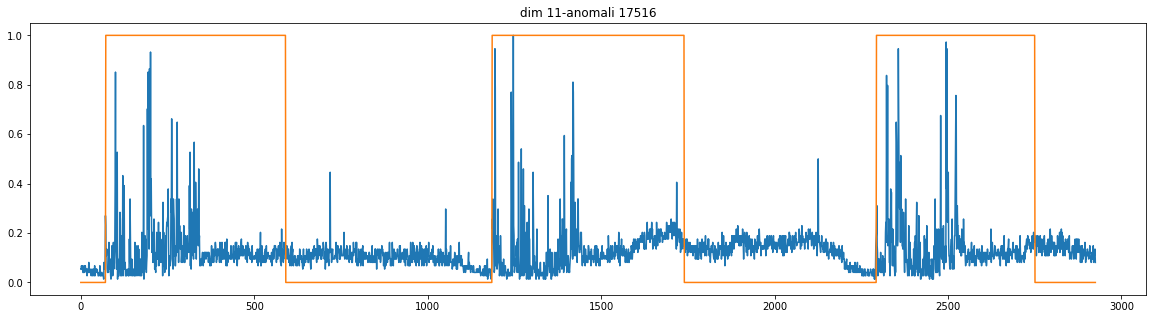

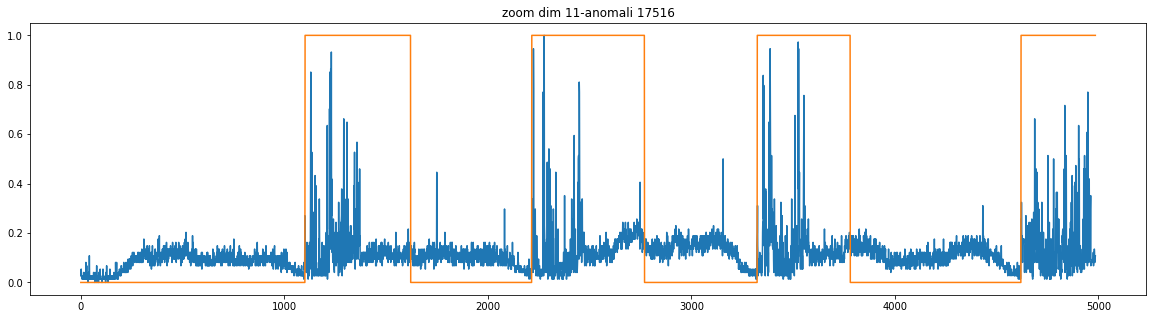

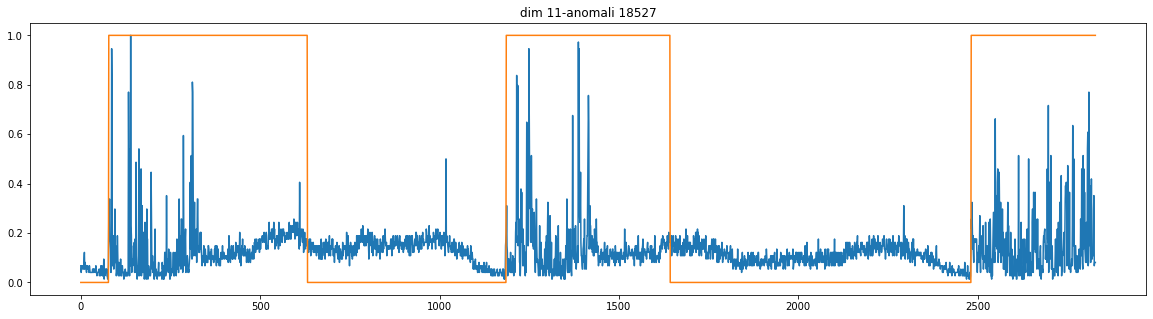

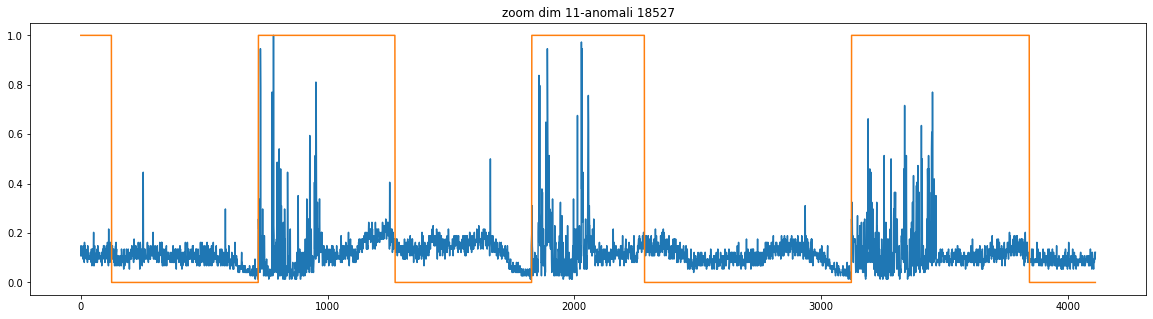

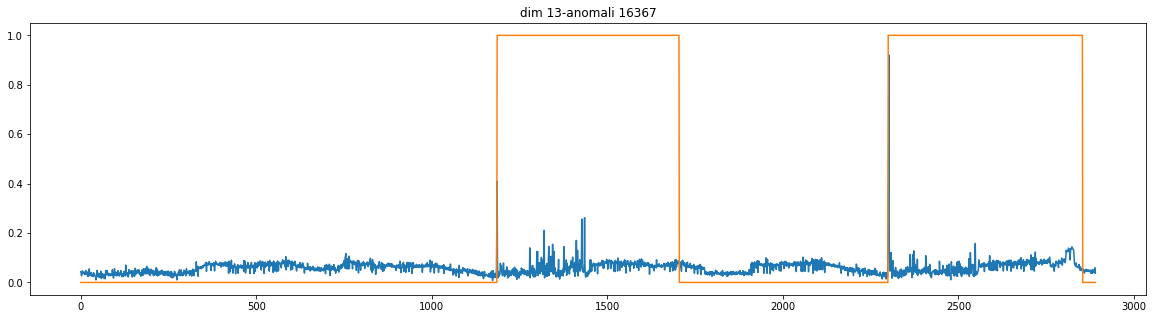

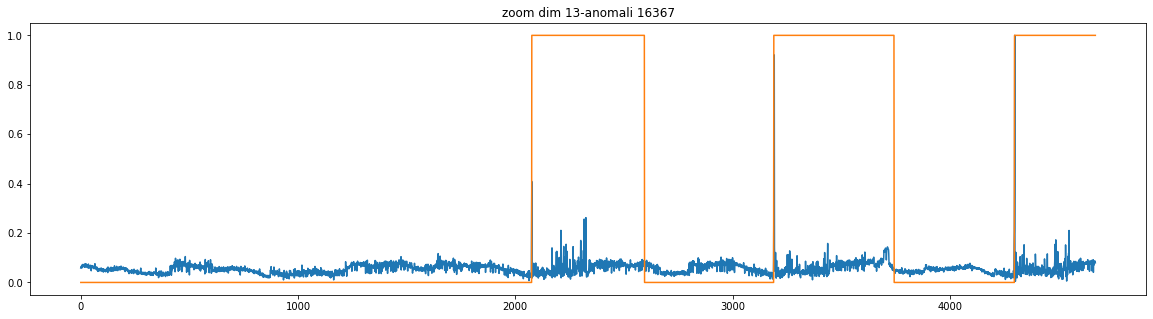

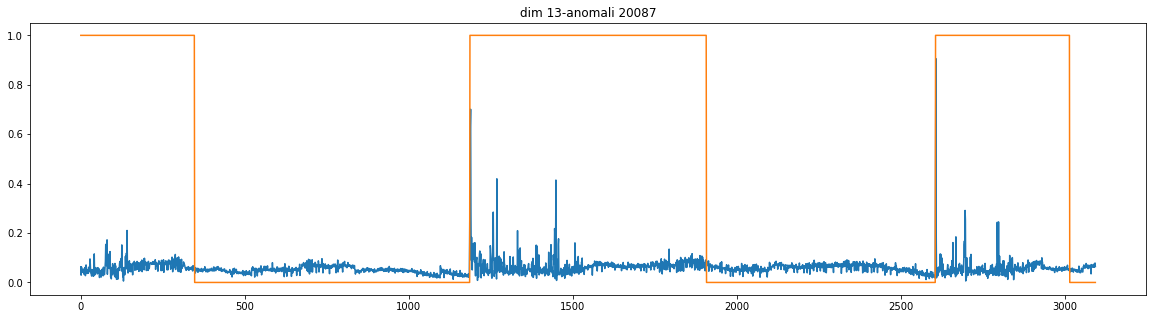

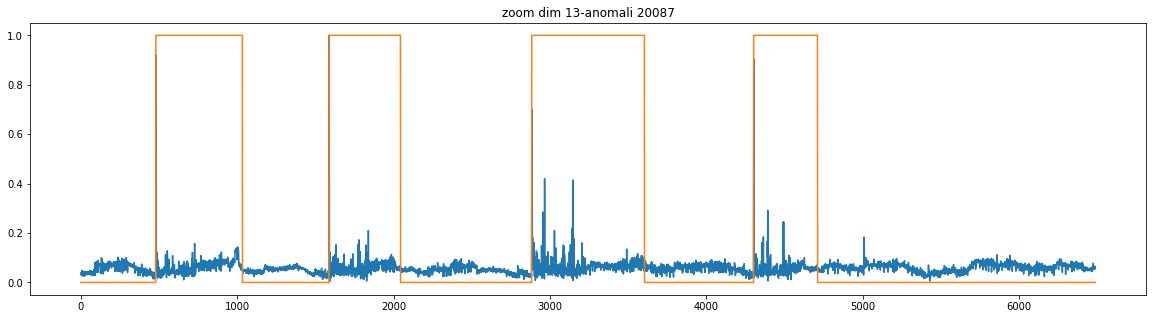

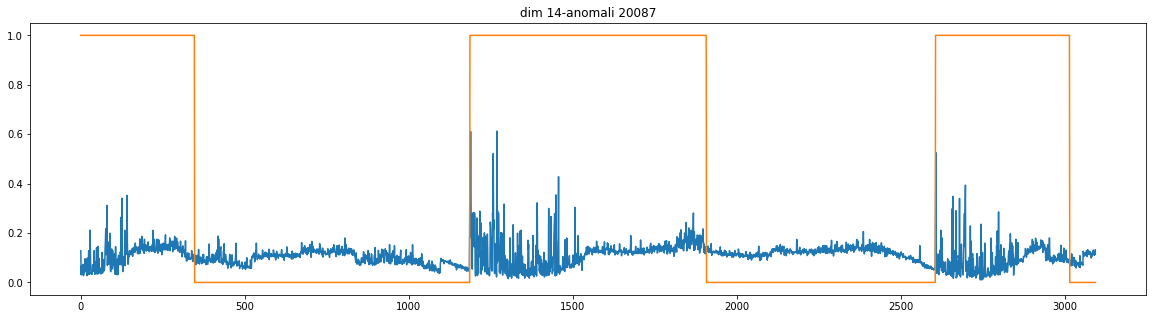

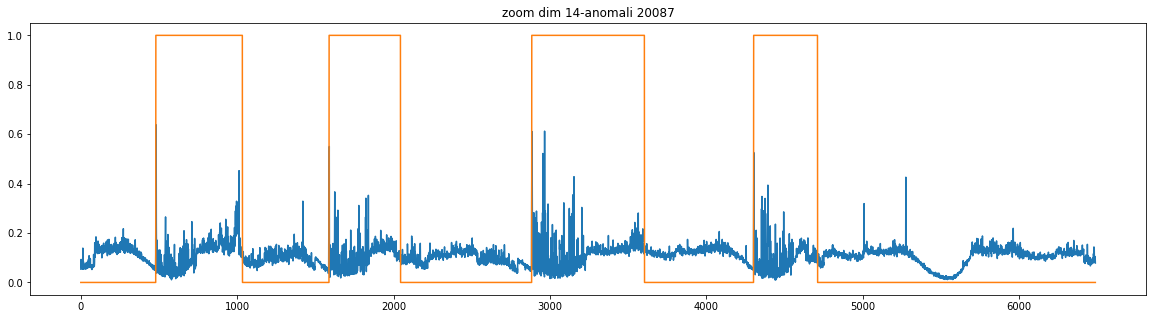

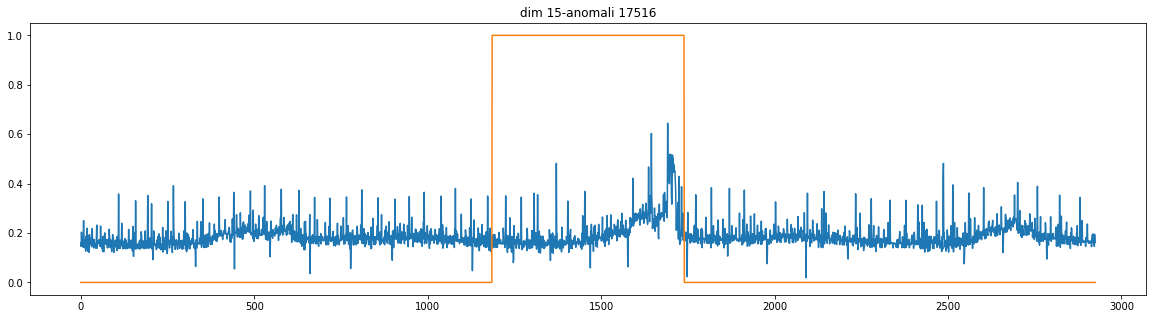

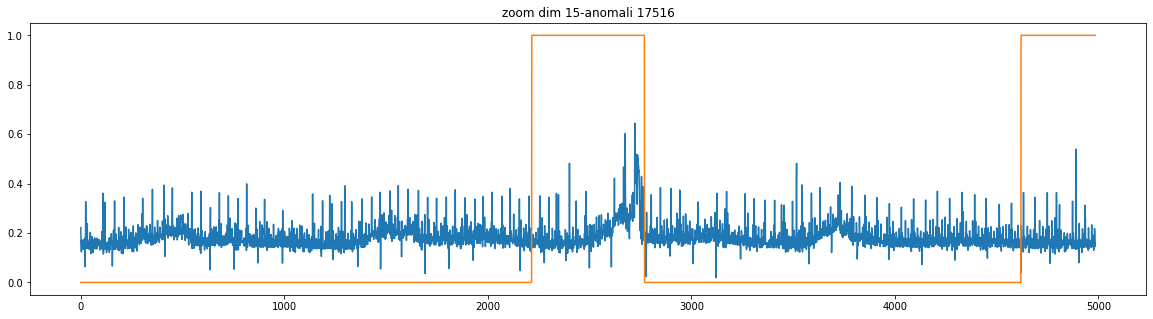

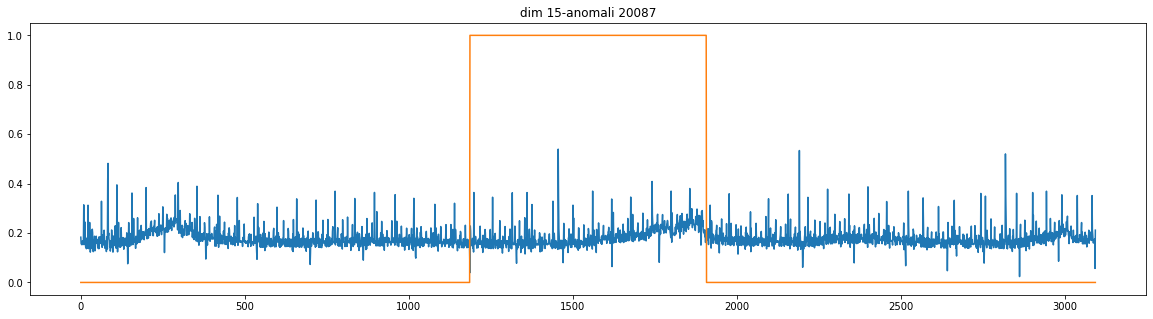

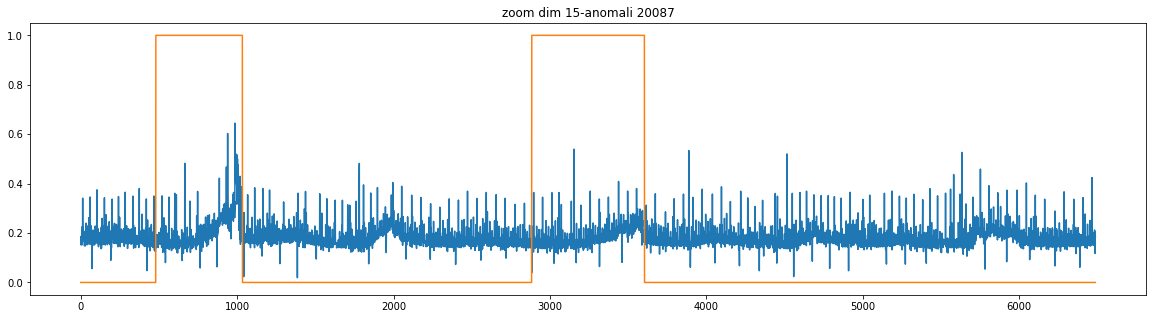

In [14]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages(f'other_results/{dataset}-{entity}.pdf')
for i in range(test.shape[1]):
    l = labels[:, i]
    y = test[:, i]

    sm = 0
    anomalies = []
    for j in range(len(l)):
        x = l[j]
        if x == 1:
            sm += 1
        else:
            if sm > 0:
                anomalies.append((j, sm))
            sm = 0

    for j, sm in anomalies:
        if (i, j-sm) in scaled_anomalies or (i, j-sm) in contextual_anomalies or (i, j-sm) in no_anomalies:
            continue
        fig = plt.figure(figsize=(20, 5))
        plt.title(f"dim {i}-anomali {j}")
        plt.plot(y[j-sm-test.shape[0]//24:j+test.shape[0]//24])
        plt.plot(l[j-sm-test.shape[0]//24:j+test.shape[0]//24])
        pp.savefig(fig)
        fig = plt.figure(figsize=(20, 5))
        plt.title(f"zoom dim {i}-anomali {j}")
        plt.plot(y[j-5*sm:j+4*sm])
        plt.plot(l[j-5*sm:j+4*sm])
        pp.savefig(fig)

pp.close()
